# 1 Balkböjning - Modul 1: icke-linjär ekvation

## 1.a)
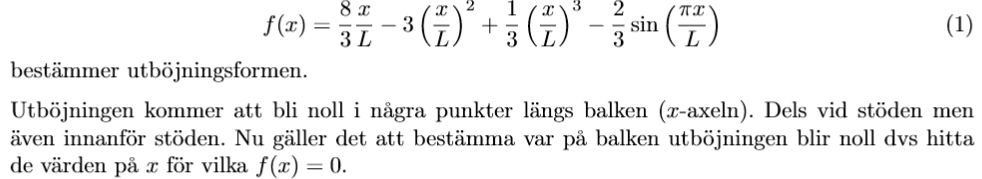


Text(0.5, 1.0, 'Bend Function')

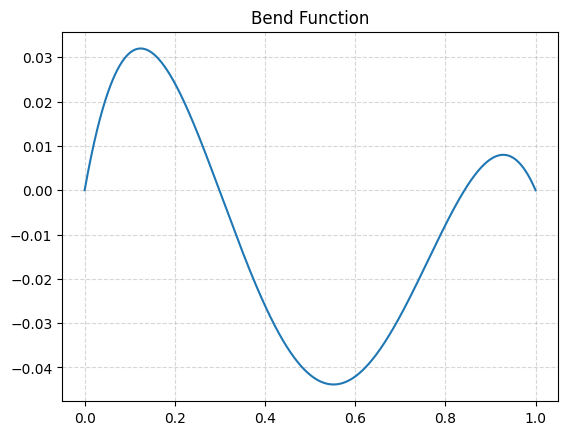

In [48]:
import numpy as np
from matplotlib import pyplot as plt

def bend_function(x: np.ndarray, L: float = 1) -> np.ndarray:
    return (8/3) * (x/L) - 3*(x/L)**2 + (1/3)*(x/L)**3 - (2/3)*np.sin(np.pi * x / L)

x: np.ndarray = np.linspace(0, 1, 1000)
y: np.ndarray = bend_function(x, L=1)

plt.plot(x, y)
plt.grid(linestyle='--', alpha=0.5)
plt.title("Bend Function")



###  **Svar 1.A:** *Förutom vid stöden finns 2 nollpunkter.*


## 1.b) 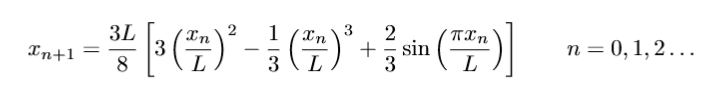

